# DRAG
> @author: Jiheng Duan

## About

This document will tell you how to scan add DRAG transform on the existing pulse, and how to scan the corresponding coefficients.

### Required Import

**The following thing must be import.**

In the current folder (despite `~\Tutorial\arb_qubit_tutorial\`), the system structure are based on file `~\System\transmon_system.py`. For using arbitrary qubit system structure, please move to the demonstration file under `~\Tutorial\arb_qubit_tutorial\`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from qutip import *
# # This on is a path correcting code, which is used to find the path of qusim.
# sys.path.append('../..')

import qusim.System.transmon_system as qs
# Some useful tools
import qusim.Instruments.tools as tools
# Some intrinsic plotting function
import qusim.DataPlot.plot_lib as pl
from qusim.PulseGen.pulse_config import PulseConfig, PulseShapeFn, DRAGConfig
from qusim.PulseGen.simulation_option import SimulationOption

# variable name -> string
def var_name2str(variable):
    def nested_var_name2str(value):
        if isinstance(value, list):
            return [nested_var_name2str(item) for item in value]
        else:
            for name in globals():
                if eval(name) == value:
                    return name
            return str(value)
    return nested_var_name2str(variable)

### Optional import

**The following import are optional**

In [2]:
# Print the full output
np.set_printoptions(threshold=sys.maxsize)

# auto reload
%load_ext autoreload
%autoreload 2 

## DRAG regime
Assume the driving pulse has shape $\Omega(t) \in \mathbb{Z}$. The pulse in derivative reduction by adiabatic gate (DRAG) regime is define by
$$
\Omega'(t) = \Omega(t) - i \lambda \frac{\dot{\Omega}(t)}{\Delta},
$$
where $\lambda$ is the DRAG scaling parameter, $\alpha$ is the anharmonicity given by $\alpha = \omega_q^{1\rightarrow 2} - \omega_q$.

After apply DRAG, and additional phase correction is required by taking the DRAG pulse into a new pulse $\Omega''(t)$ as
$$
\Omega''(t) = \Omega'(t) e^{i2\pi \delta f (t- t_0)}
$$
where $\delta f$ is a pulse frequency detuning parameter and $t_0$ is the center position of the pulse.

If we add an additional pulse detuning correction to the microwave, we should redefine the anharmonicity used in the DRAG correction by replacing $\alpha$ by $\Delta $:
$$
\Omega'(t) = \Omega(t) - i \lambda \frac{\dot{\Omega}(t)}{\Delta},
$$

In our code, the DRAG regime can be turned on for `'XY'` pulses, which can be added in `pulse_sequence`. The correspondences are:
>* $\lambda$: `'DRAG_scale'`
>* $\Delta$: `'DRAG_delta'`
>* $\delta f$: ``'pulse_detuning'``

Notice that the protocol here allows the user to input a list of `'DRAG_scale'` and `'DRAG_delta'` to achieve multiple DRAG on a single pulse.

### How to setup DRAG?
#### Setup system

In [29]:
N = None
w = [6.3] # Qubit frequency
q_dim = [3 for _ in range(len(w))] # Dimension of each qubit
alpha =[-0.3] # Anharmonicity
r=  0
gamma_list = None

# Set up system class
_system = qs.TransmonSys(N, q_dim, w, alpha, r, gamma_list)

state_0, E_0, index_0 = _system.get_eigenstates_energy((0,))
state_1, E_1, index_1 = _system.get_eigenstates_energy((1,))
state_2, E_2, index_2 = _system.get_eigenstates_energy((2,))

sim_opt = SimulationOption(simu_time=30, simu_point=15000, init_state=[ket2dm(state_0)])

#### Define Pulse sequence with DRAG

We use `DRAGConfig()` to config a single DRAG transform to the pulse. The PulseConfig takes an input of a `list` of `DRAGConfig`.

To define a `DRAGConfig`, it takes the form `DRAGConfig(scale=my_DRAG_scale, delta=my_DRAG_delta)`. 

To call the attributes in your `DRAGConfig`, use `DRAGConfig.scale` and `DRAGConfig.delta`.

See `DRAGConfig.__doc__` for usage anytime.

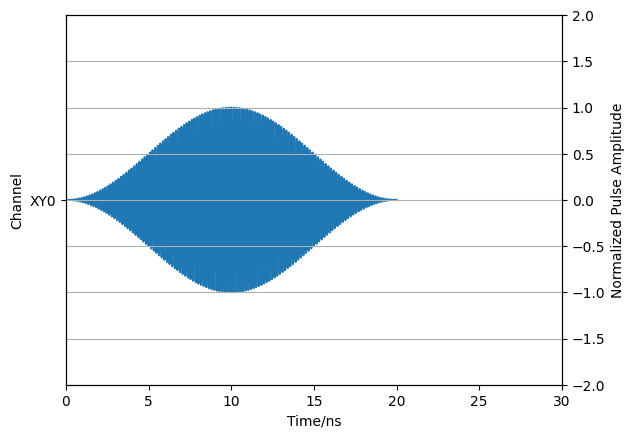

0

In [30]:
pulse_sequence = [
    PulseConfig(
        pulse_index=1,
        pulse_type="XY",
        pulse_shape=PulseShapeFn.COSINE,
        t_delay=0,
        t_width=20,
        t_plateau=0,
        frequency=6.3,
        phase=0,
        amplitude=0.05,
        qindex=0,
        DRAG_config_list=[DRAGConfig(scale=1, delta=-0.3)],
        frequency_detuning=0.001688
    )
]

pl.plot_pulse_sequence(pulse_sequence, sim_opt)

#### Do system dynamics and plot the result

In [31]:
result_list, angle_list = _system.system_dynamics_mesolve(pulse_sequence, sim_opt)

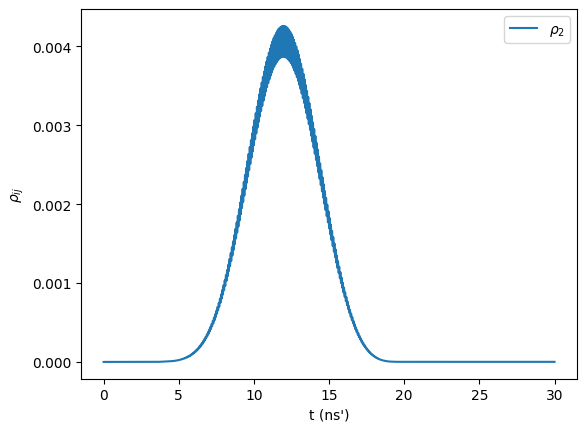

In [32]:
t = sim_opt.tlist

# Select which result you want to see
result = result_list[0]

# Plot
%matplotlib inline

# plt.plot(t,qs.expect(result.states, state_0 * state_0.dag()), label=r'$\rho_{0}$');
# plt.plot(t,qs.expect(result.states, state_1 * state_1.dag()), label=r'$\rho_{1}$');
plt.plot(t,qs.expect(result.states, state_2 * state_2.dag()), label=r'$\rho_{2}$');
plt.ylabel(r"$\rho_{ij}$")
plt.xlabel("t (ns')")
plt.legend()
plt.show()

### Multiple DRAG case

In [ ]:
pulse_sequence = [
    PulseConfig(
        pulse_index=1,
        pulse_type="XY",
        pulse_shape=PulseShapeFn.COSINE,
        t_delay=0,
        t_width=20,
        frequency=6.3,
        t_plateau=0,
        phase=0,
        amplitude=0.04,
        qindex=0,
        DRAG_config_list=[DRAGConfig(scale=0.2, delta=-0.3), DRAGConfig(scale=1, delta=-0.2), DRAGConfig(scale=0.3, delta=-0.4), DRAGConfig(scale=1,delta=-0.5)],
        frequency_detuning=0.001688,
    )
]

pl.plot_pulse_sequence(pulse_sequence, sim_opt)

### Scanning DRAG parameter

In this section, we will show you how to scan the DRAG parameter, including `'DRAG_scale'`, `'DRAG_delta'`, and `'pulse_detuning'`.

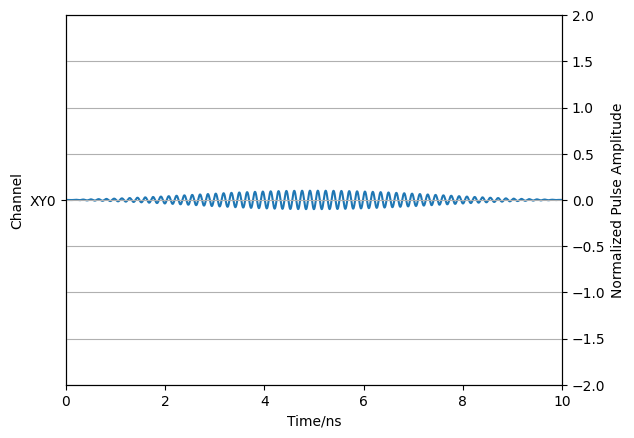

0

In [34]:
N = None
w = [6.3] # Qubit frequency
q_dim = [3 for _ in range(len(w))] # Dimension of each qubit
alpha =[-0.3] # Anharmonicity
r = 0
gamma_list = None

# Set up system class
_system = qs.TransmonSys(N, q_dim, w, alpha, r, gamma_list)

state_0, E_0, index_0 = _system.get_eigenstates_energy((0,))
state_1, E_1, index_1 = _system.get_eigenstates_energy((1,))
state_2, E_2, index_2 = _system.get_eigenstates_energy((2,))

simopt = SimulationOption(simu_time=10, simu_point=100000, init_state=[ket2dm(state_0)])
pulse_sequence = [
    PulseConfig(
        pulse_index=1,
        pulse_type="XY",
        pulse_shape=PulseShapeFn.COSINE,
        t_delay=0,
        t_width=10,
        frequency=6.3,
        t_plateau=0,
        phase=0,
        amplitude=0.1,
        qindex=0,
        DRAG_config_list=[DRAGConfig(scale=1, delta=-0.2766917293)],
        frequency_detuning=0.0037593985,
    )
]
pl.plot_pulse_sequence(pulse_sequence, simopt)

#### Before DRAG

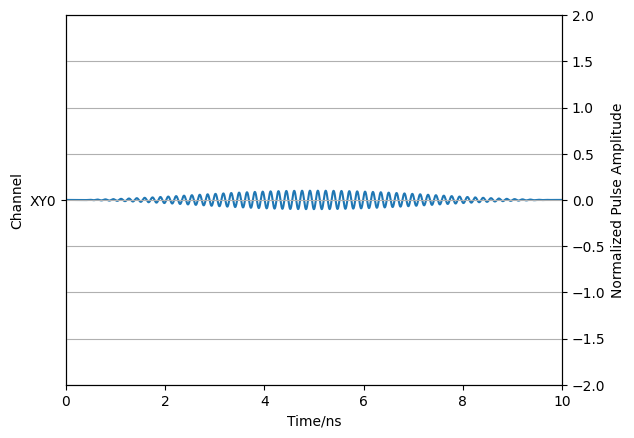

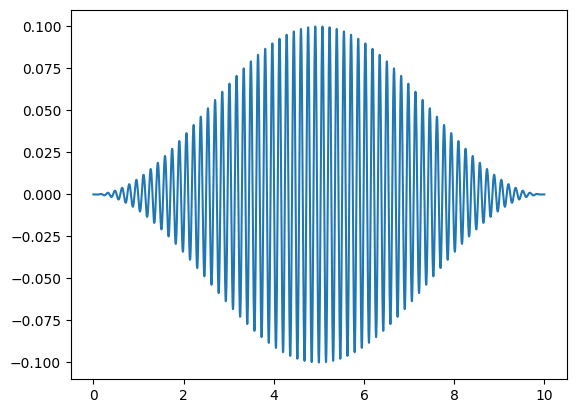

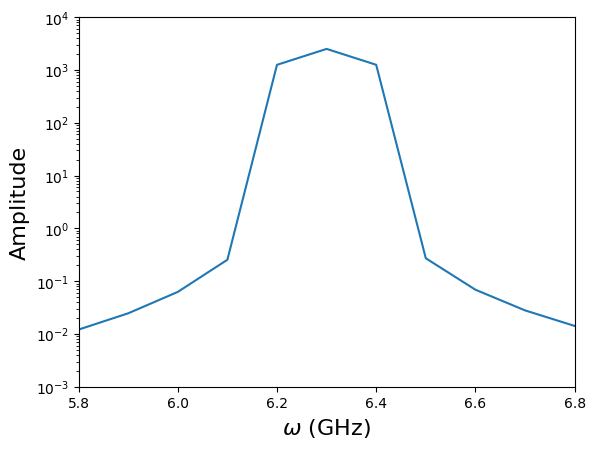

In [48]:
pulse_sequence_noDRAG = [
    PulseConfig(
        pulse_index=1,
        pulse_type="XY",
        pulse_shape=PulseShapeFn.COSINE,
        t_delay=0,
        t_width=10,
        frequency=6.3,
        t_plateau=0,
        phase=0,
        amplitude=0.1,
        qindex=0,
    )
]
pl.plot_pulse_sequence(pulse_sequence_noDRAG, simopt)

tlist = simopt.tlist
freqlist = np.fft.fftfreq(simopt.simulation_point, d=tlist[1]-tlist[0])

drive_pulse = pulse_sequence_noDRAG[0].get_pulse(simopt)

plt.figure(1)
plt.plot(tlist, drive_pulse)
fft_waveform_noDRAG = np.fft.fft(drive_pulse)
plt.figure(2)
plt.plot(freqlist, np.abs(fft_waveform_noDRAG))
plt.xlim([5.8,6.8])
plt.ylim(1e-3,1e4)
plt.ylabel('Amplitude', fontsize=16)
plt.xlabel(r"$\omega$ (GHz)", fontsize=16)
plt.yscale('log')

#### Test DRAG

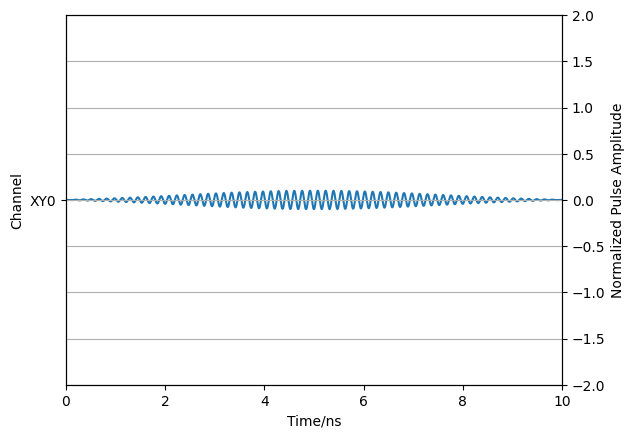

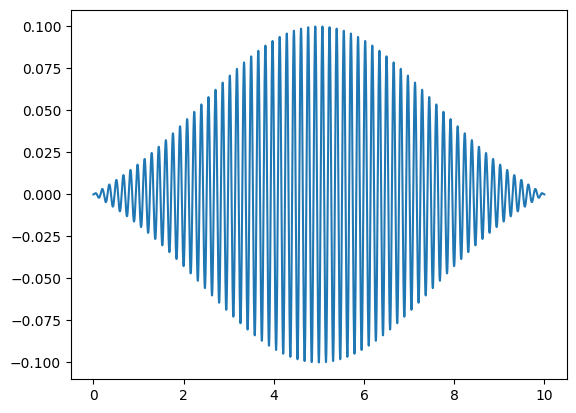

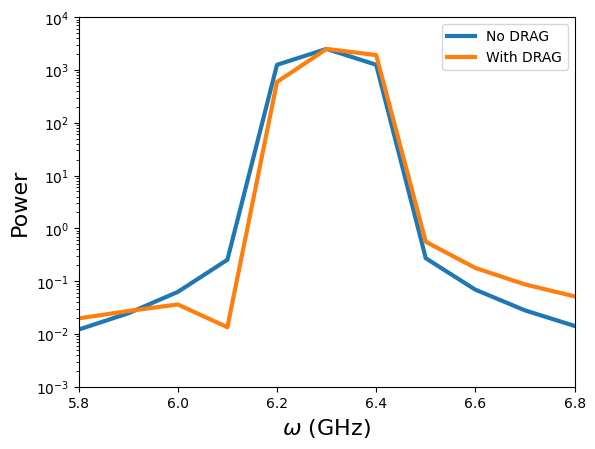

In [59]:
pulse_sequence_withDRAG = [
    PulseConfig(
        pulse_index=1,
        pulse_type="XY",
        pulse_shape=PulseShapeFn.COSINE,
        t_delay=0,
        t_width=10,
        frequency=6.3,
        t_plateau=0,
        phase=0,
        amplitude=0.1,
        qindex=0,
        DRAG_config_list=[DRAGConfig(scale=1, delta=-0.19)]
    )
]
pl.plot_pulse_sequence(pulse_sequence_withDRAG, simopt)

tlist = simopt.tlist
freqlist = np.fft.fftfreq(simopt.simulation_point, d=tlist[1]-tlist[0])

drive_pulse = pulse_sequence_withDRAG[0].get_pulse(simopt)

plt.figure(1)
plt.plot(tlist, drive_pulse)
fft_waveform_withDRAG = np.fft.fft(drive_pulse)
plt.figure(2)
plt.plot(freqlist, np.abs(fft_waveform_noDRAG), label="No DRAG", linewidth=3)
plt.plot(freqlist, np.abs(fft_waveform_withDRAG), label="With DRAG", linewidth=3)

plt.xlim([5.8,6.8])
plt.ylim(1e-3,1e4)
plt.ylabel('Power', fontsize=16)
plt.xlabel(r"$\omega$ (GHz)", fontsize=16)
plt.legend()
plt.yscale('log')

In [131]:
result_list, angle_list = _system.system_dynamics_mesolve(pulse_sequence, simopt)

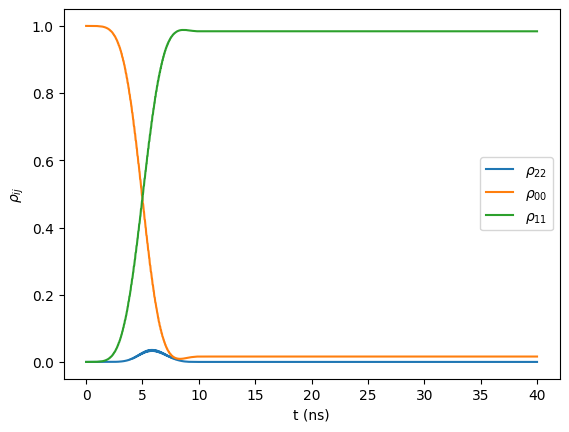

In [132]:
t = simopt.tlist

# Select which result you want to see
result = result_list[0]

# Plot
%matplotlib inline

plt.plot(t,qs.expect(result.states, state_2 * state_2.dag()), label=r'$\rho_{22}$');
plt.plot(t,qs.expect(result.states, state_0 * state_0.dag()), label=r'$\rho_{00}$');
plt.plot(t,qs.expect(result.states, state_1 * state_1.dag()), label=r'$\rho_{11}$');
plt.ylabel(r"$\rho_{ij}$")
plt.xlabel("t (ns)")
plt.legend()
plt.show()

In [134]:
qs.expect(result.states, state_1 * state_1.dag())[-1]

0.9839941318183911